<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Stock_Prices_Anomaly_Detection_using_PCA_LSTMv1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the experiment, we will be able to :

* apply PCA based analysis on various stocks data
* analyze and create time series data
* implement LSTM auto-encoders
* detect the anomalies based on the loss


## Information

Autoencoder Neural Networks try to learn data representation of its input. Usually, we want to learn an efficient encoding that uses fewer parameters/memory. The encoding should allow for output similar to the original input. In a sense, we’re forcing the model to learn the most important features of the data using as few parameters as possible.

LSTM autoencoder is an encoder that makes use of LSTM encoder-decoder architecture to compress data using an encoder and decode it to retain original structure using a decoder.

**Anomaly Detection**

Anomaly detection refers to the task of finding/identifying rare events/data points. Some applications include - bank fraud detection, tumor detection in medical imaging, and errors in written text.

A lot of supervised and unsupervised approaches for anomaly detection have been proposed. Some of the approaches include - One-class SVMs, Bayesian Networks, Cluster analysis, and Neural Networks.

We will use an LSTM Autoencoder Neural Network to detect/predict anomalies (sudden price changes) in the S&P 500 index.

## Dataset



This mini-project consists of two parts and two different stock price datasets:

### PART A

Using the **S&P 500 stock prices data of different companies**, we will perform a PCA based analysis.

### PART B

Using the **S&P 500 stock price index time series data**, we will perform anomaly detection in the stock prices across the years. The dataset chosen is is S&P500 Daily Index a .csv format with one column with a daily timestamp and the second column with the raw, un-adjusted closing prices for each day. This long term, granular time series dataset allows researchers to have a good sized publicly available financial dataset to explore time series trends or use as part of a quantitative finance project.

## Problem Statement

Detect the stock price anomalies by implementing an LSTM autoencoder

In [ ]:
#@title Download dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/SPY.csv
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/prices.csv

### Import required packages

In [ ]:
import keras
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## PCA Analysis (PART-A)

Principal Component Analysis (PCA) decomposes the data into many vectors called principal components. These summaries are linear combinations of the input features that try to explain as much variance in the data as possible. By convention, these principal components are ordered by the amount of variance they can explain, with the first principal component explaining most of the data.

Perform PCA based analytics on the stock prices data from different companies.

### Load and pre-process the prices data

In [ ]:
prices_path = "prices.csv"
df_stocks = pd.read_csv(prices_path)
df_stocks.info()
df_stocks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Columns: 503 entries, A to ZTS
dtypes: float64(503)
memory usage: 1.5 MB


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85.017082,28.982893,157.171890,74.207466,81.950539,82.938141,168.809998,84.622925,204.910950,334.429993,...,59.934875,100.115349,63.633118,56.203197,78.396255,99.349007,147.579269,259.140015,49.903751,132.803421
2,83.652077,27.548195,157.181747,73.486023,81.172668,81.895088,166.820007,83.591301,204.569687,331.809998,...,60.223114,97.810677,63.121540,55.581242,78.857689,99.037834,147.193512,256.049988,49.199547,132.823227
3,83.899353,27.219410,154.598541,74.071579,81.813271,83.094116,179.039993,84.029251,203.233841,333.709991,...,60.136642,95.771927,63.606186,55.887280,78.347168,98.979500,146.342834,258.010010,48.600010,131.803482
4,84.156532,27.119778,152.764648,73.723213,81.346550,82.499466,180.350006,83.562103,198.846008,333.390015,...,60.011738,97.958405,63.085632,56.183449,78.052628,99.154533,146.214264,256.470001,48.305000,132.248978


In [ ]:
# Remove the first row which is NaN values
df_stocks = df_stocks.drop(0)
df_stocks.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1,85.017082,28.982893,157.171890,74.207466,81.950539,82.938141,168.809998,84.622925,204.910950,334.429993,...,59.934875,100.115349,63.633118,56.203197,78.396255,99.349007,147.579269,259.140015,49.903751,132.803421
2,83.652077,27.548195,157.181747,73.486023,81.172668,81.895088,166.820007,83.591301,204.569687,331.809998,...,60.223114,97.810677,63.121540,55.581242,78.857689,99.037834,147.193512,256.049988,49.199547,132.823227
3,83.899353,27.219410,154.598541,74.071579,81.813271,83.094116,179.039993,84.029251,203.233841,333.709991,...,60.136642,95.771927,63.606186,55.887280,78.347168,98.979500,146.342834,258.010010,48.600010,131.803482
4,84.156532,27.119778,152.764648,73.723213,81.346550,82.499466,180.350006,83.562103,198.846008,333.390015,...,60.011738,97.958405,63.085632,56.183449,78.052628,99.154533,146.214264,256.470001,48.305000,132.248978
5,84.987411,27.737495,151.009644,74.909149,81.923080,83.298828,178.690002,83.902740,199.236069,337.869995,...,59.954086,97.682640,62.134274,56.775787,78.317703,99.329567,147.965027,247.639999,48.780827,131.961884


In [ ]:
df_stocks

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1,85.017082,28.982893,157.171890,74.207466,81.950539,82.938141,168.809998,84.622925,204.910950,334.429993,...,59.934875,100.115349,63.633118,56.203197,78.396255,99.349007,147.579269,259.140015,49.903751,132.803421
2,83.652077,27.548195,157.181747,73.486023,81.172668,81.895088,166.820007,83.591301,204.569687,331.809998,...,60.223114,97.810677,63.121540,55.581242,78.857689,99.037834,147.193512,256.049988,49.199547,132.823227
3,83.899353,27.219410,154.598541,74.071579,81.813271,83.094116,179.039993,84.029251,203.233841,333.709991,...,60.136642,95.771927,63.606186,55.887280,78.347168,98.979500,146.342834,258.010010,48.600010,131.803482
4,84.156532,27.119778,152.764648,73.723213,81.346550,82.499466,180.350006,83.562103,198.846008,333.390015,...,60.011738,97.958405,63.085632,56.183449,78.052628,99.154533,146.214264,256.470001,48.305000,132.248978
5,84.987411,27.737495,151.009644,74.909149,81.923080,83.298828,178.690002,83.902740,199.236069,337.869995,...,59.954086,97.682640,62.134274,56.775787,78.317703,99.329567,147.965027,247.639999,48.780827,131.961884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,147.580002,18.969999,205.669998,142.449997,115.419998,112.599998,314.619995,118.790001,309.179993,602.049988,...,68.269997,129.330002,55.349998,60.689999,117.230003,113.449997,150.169998,506.910004,47.700001,197.580002
390,149.300003,20.559999,210.229996,146.149994,116.050003,116.489998,323.589996,118.730003,312.059998,608.719971,...,68.160004,131.100006,55.959999,62.580002,121.529999,116.160004,155.630005,519.669983,50.200001,200.110001
391,148.949997,21.400000,209.399994,145.399994,116.989998,118.220001,322.850006,118.980003,313.769989,612.260010,...,67.059998,135.330002,57.759998,63.759998,122.430000,116.769997,159.570007,533.770020,51.639999,198.039993
392,150.300003,21.160000,210.289993,146.800003,117.540001,119.839996,323.540009,118.250000,314.260010,623.679993,...,67.239998,136.470001,57.110001,63.299999,122.000000,120.260002,158.660004,536.219971,50.320000,200.539993


In [ ]:
df_stocks_clean = df_stocks

# Impute column mean for any NaN values
column_means = df_stocks_clean.mean()

# df_stocks_clean = df_stocks_clean.fillna(column_means)
df_stocks_clean = df_stocks_clean.fillna(column_means)

# pd.reset_option('display.max_rows')
print(df_stocks_clean.isnull().sum().sum())
df_stocks_clean


0


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1,85.017082,28.982893,157.171890,74.207466,81.950539,82.938141,168.809998,84.622925,204.910950,334.429993,...,59.934875,100.115349,63.633118,56.203197,78.396255,99.349007,147.579269,259.140015,49.903751,132.803421
2,83.652077,27.548195,157.181747,73.486023,81.172668,81.895088,166.820007,83.591301,204.569687,331.809998,...,60.223114,97.810677,63.121540,55.581242,78.857689,99.037834,147.193512,256.049988,49.199547,132.823227
3,83.899353,27.219410,154.598541,74.071579,81.813271,83.094116,179.039993,84.029251,203.233841,333.709991,...,60.136642,95.771927,63.606186,55.887280,78.347168,98.979500,146.342834,258.010010,48.600010,131.803482
4,84.156532,27.119778,152.764648,73.723213,81.346550,82.499466,180.350006,83.562103,198.846008,333.390015,...,60.011738,97.958405,63.085632,56.183449,78.052628,99.154533,146.214264,256.470001,48.305000,132.248978
5,84.987411,27.737495,151.009644,74.909149,81.923080,83.298828,178.690002,83.902740,199.236069,337.869995,...,59.954086,97.682640,62.134274,56.775787,78.317703,99.329567,147.965027,247.639999,48.780827,131.961884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,147.580002,18.969999,205.669998,142.449997,115.419998,112.599998,314.619995,118.790001,309.179993,602.049988,...,68.269997,129.330002,55.349998,60.689999,117.230003,113.449997,150.169998,506.910004,47.700001,197.580002
390,149.300003,20.559999,210.229996,146.149994,116.050003,116.489998,323.589996,118.730003,312.059998,608.719971,...,68.160004,131.100006,55.959999,62.580002,121.529999,116.160004,155.630005,519.669983,50.200001,200.110001
391,148.949997,21.400000,209.399994,145.399994,116.989998,118.220001,322.850006,118.980003,313.769989,612.260010,...,67.059998,135.330002,57.759998,63.759998,122.430000,116.769997,159.570007,533.770020,51.639999,198.039993
392,150.300003,21.160000,210.289993,146.800003,117.540001,119.839996,323.540009,118.250000,314.260010,623.679993,...,67.239998,136.470001,57.110001,63.299999,122.000000,120.260002,158.660004,536.219971,50.320000,200.539993


**Why apply log to daily returns?**

Stabilizing Variance: In many time series datasets, the variance of the observations tends to increase or decrease over time, resulting in heteroscedasticity. Applying the logarithmic transformation can help stabilize the variance. This is because the logarithmic function compresses large values and expands small values. In financial time series, stock prices often exhibit increasing volatility over time, and taking the logarithm can help mitigate this.

Linearization: In some cases, the logarithm is applied to linearize relationships in the data. For example, if the relationship between variables is multiplicative rather than additive, taking the logarithm can transform it into an additive relationship. This can be beneficial when modeling or interpreting relationships.

Stationarity: Stationarity is a key assumption in many time series models. A stationary time series is one whose statistical properties (mean, variance, and autocorrelation) do not change over time. By stabilizing the variance through the logarithmic transformation, it can make the data more likely to satisfy the stationarity assumption.

In [ ]:
# Make the data stationay - see comment above
rs = df_stocks_clean.apply(np.log).diff(1)
rs.isnull().sum().sum()

503

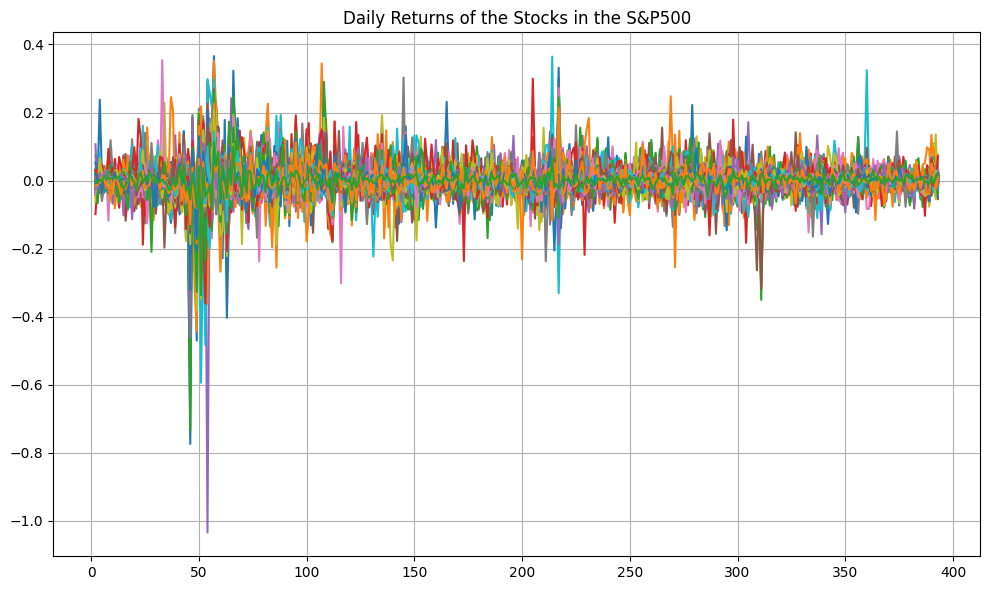

In [ ]:
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

### Apply PCA

* plot the explained variance ratio. Hint: `pca.explained_variance_ratio_`
* Represent the components which preserve maximum information and plot to visualize
* Compute the daily returns of the 500 company stocks.
* Plot the stocks with most negative and least negative PCA weights in the pandemic period (Year 2020). Use reference as above. Discuss the least and most impacted industrial sectors in terms of stocks.

In [ ]:
pca = PCA(n_components = 200)
df_stocks_red = pca.fit_transform(rs.fillna(0));

# Components that represent the maximum information
print("Total principal components: ",len(pca.explained_variance_ratio_))
print("The first 15 principal components:\n",pca.explained_variance_ratio_[0:15])


Total principal components:  200
The first 15 principal components:
 [0.51169392 0.0705496  0.03824935 0.03008043 0.02044299 0.01434081
 0.0132432  0.01041922 0.00990074 0.00873515 0.00847027 0.00762095
 0.00702234 0.00670952 0.00607531]


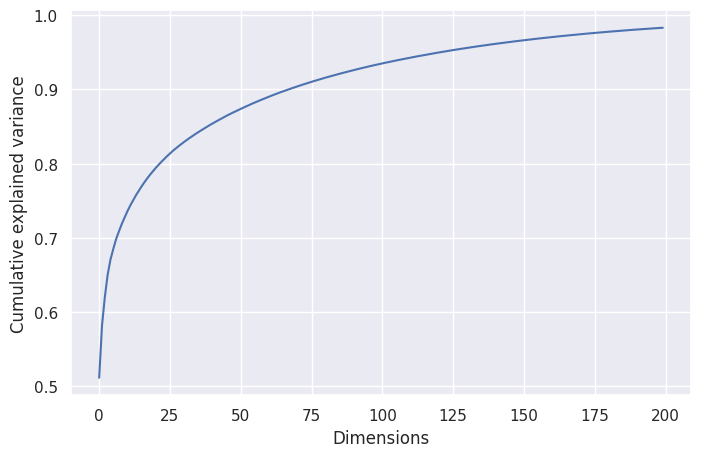

In [ ]:
# Visualize Explained variance as a function of the number of dimensions
sns.set(rc={'figure.figsize':(8,5)})
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('Dimensions')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Apply T-SNE and visualize with a graph

In [ ]:
rs_clean = rs.fillna(0)

In [ ]:
rs_clean.isnull().sum().sum()

0

In [ ]:
# Instantiate tsne from sklearn
tsne = TSNE(n_components=2, perplexity=15, init='pca', random_state=0)
# Implement tsne - use the transpose of the daily returns matrix
rs_clean_tsne = tsne.fit_transform(rs_clean.T)


In [ ]:
rs_clean_tsne.shape, type(rs_clean_tsne)

((503, 2), numpy.ndarray)

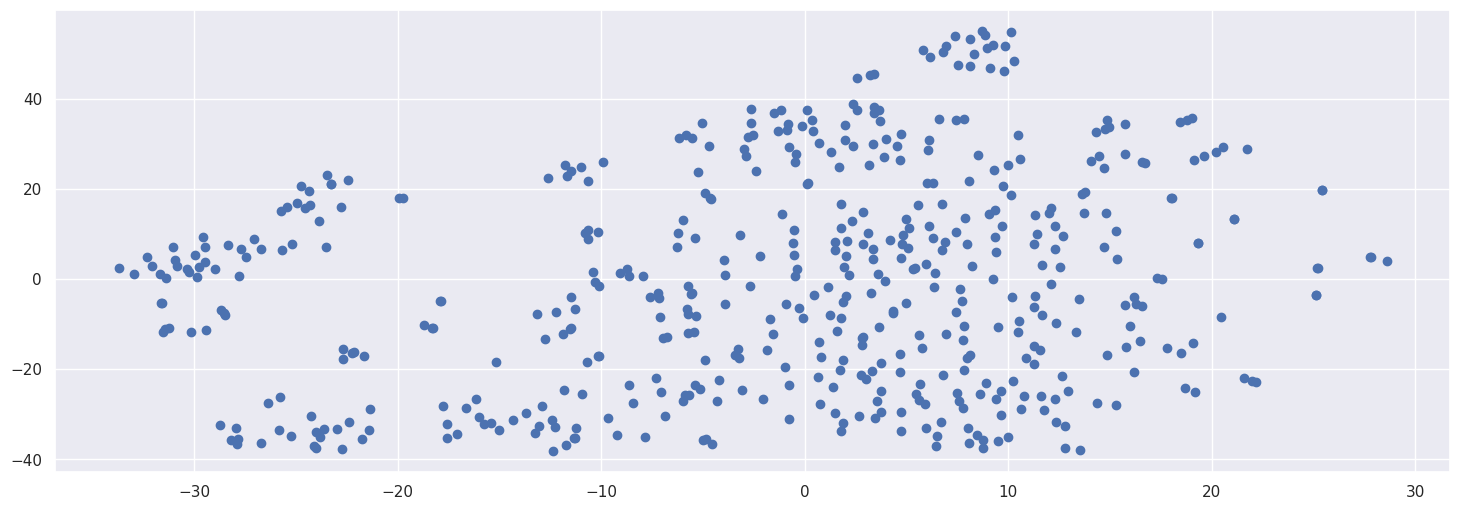

In [ ]:
# Display the points after t-SNE transformation - try to spot clusters
x = rs_clean_tsne[:, 0]
y = rs_clean_tsne[:, 1]
plt.figure(figsize=(18, 6))
plt.scatter(x,y)
plt.show()

In [ ]:
col_name = rs_clean.T.index
rs_clean_tsne_red = pd.DataFrame(rs_clean_tsne, columns=['X','Y'])
rs_clean_tsne_red['Comp'] = col_name
rs_clean_tsne_red

,X,Y,Comp
0,-5.129539,-24.458645,A
1,14.863611,35.157543,AAL
2,-18.698324,-10.139435,AAP
3,-11.227837,-32.942219,AAPL
4,12.294801,-26.541298,ABBV
...,...,...,...
498,-5.330275,-8.098748,YUM
499,-8.720128,2.291274,ZBH
500,-15.175044,-18.319180,ZBRA
501,-1.178171,37.564293,ZION


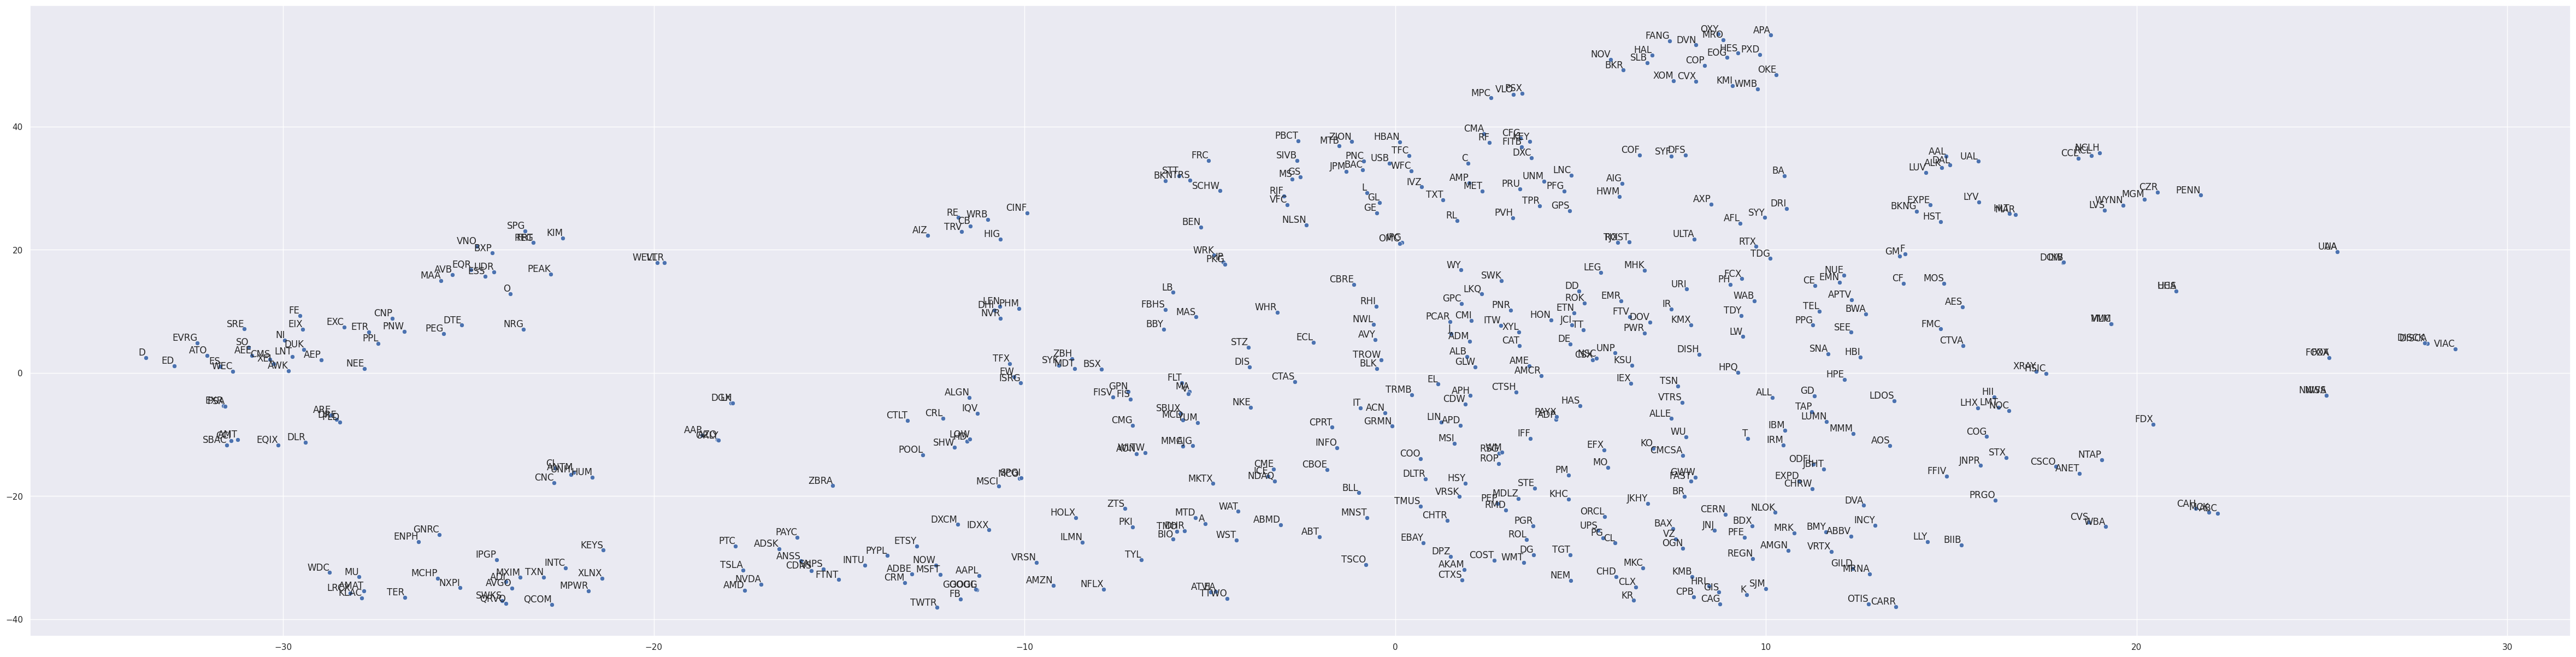

In [ ]:
# Visualize red stock dataset
sns.set(rc={'figure.figsize':(60,15)})

xs=x
ys=y
sns.scatterplot(x=xs, y=ys)

for i, name in enumerate(rs_clean.T.index):
    plt.text(rs_clean_tsne_red['X'][i], rs_clean_tsne_red['Y'][i], name, ha='right', va='bottom')
plt.show()

## Anomaly Detection (PART-B)

### Load and Preprocess the data

* Inspect the S&P 500 Index Data

In [ ]:
path = 'SPY.csv'
df_spy = pd.read_csv(path)
df_spy.info()
df_spy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7134 entries, 0 to 7133
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7134 non-null   object 
 1   Open       7134 non-null   float64
 2   High       7134 non-null   float64
 3   Low        7134 non-null   float64
 4   Close      7134 non-null   float64
 5   Adj Close  7134 non-null   float64
 6   Volume     7134 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 390.3+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.983273,480500
1,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.038315,201300
2,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.313566,529400
3,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.423655,531500
4,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.405315,492100


#### Data Preprocessing

In [ ]:
# Null check
df_spy.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# Covert Date object to datetime data type and extract the column of interest and set date as index
df_spy["Date"] = pd.to_datetime(df_spy["Date"])

df_spy_to_plot = df_spy[['Date','Close']]
df_spy_to_plot = df_spy_to_plot.set_index("Date")

df_spy_to_plot


,Close
Date,
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
1993-02-05,44.968750
...,...
2021-05-24,419.170013
2021-05-25,418.239990
2021-05-26,419.070007


Historical Index value visualization:


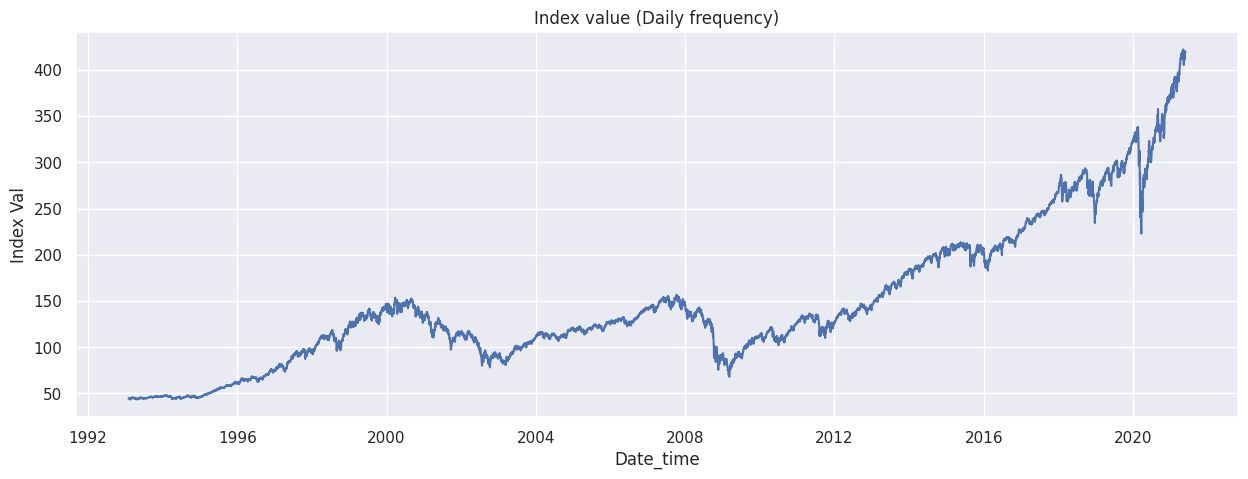

In [ ]:
print('Historical Index value visualization:')
plt.figure(figsize = (15,5))
plt.plot(df_spy_to_plot)
plt.title('Index value (Daily frequency)')
plt.xlabel ('Date_time')
plt.ylabel ('Index Val')
plt.show()

In [ ]:
# Calculate each monthly average - this will be used to make the data stationary
monthly_average = df_spy_to_plot.resample('M').mean()
monthly_average

,Close
Date,
1993-02-28,44.291118
1993-03-31,45.119565
1993-04-30,44.357143
1993-05-31,44.662500
1993-06-30,44.991477
...,...
2021-01-31,378.178423
2021-02-28,387.481577
2021-03-31,390.286959


In [ ]:
# Some contrived way of dividing daily closing price with monthly average to get rid of trend and seasonality
# Maybe this can be done differently?

# avg = monthly_average.iloc[0][0]
# count = 0
# month_prev = 2

# for idx, row in df_spy_to_plot.iterrows():
#     month = idx.month
#     if month != month_prev:
#         month_prev = month
#         count=count+1
#         avg = monthly_average.iloc[count][0]

#     df_spy_to_plot.at[idx, 'Close'] = row['Close'] / avg


In [ ]:
# Quick look at the dataframe
df_spy_to_plot

,Close
Date,
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
1993-02-05,44.968750
...,...
2021-05-24,419.170013
2021-05-25,418.239990
2021-05-26,419.070007


In [ ]:
# Tests to show that the data is stationary
# Import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(df_spy_to_plot)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(df_spy_to_plot)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.999
KPSS test:	p-value: 0.010


<ipython-input-25-2b39009ac621>:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_spy_to_plot)


In [ ]:
df_spy_to_plot.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,7134.0,147.288628,76.90221,43.40625,100.442501,127.780003,187.525002,422.119995


Historical Index value visualization:


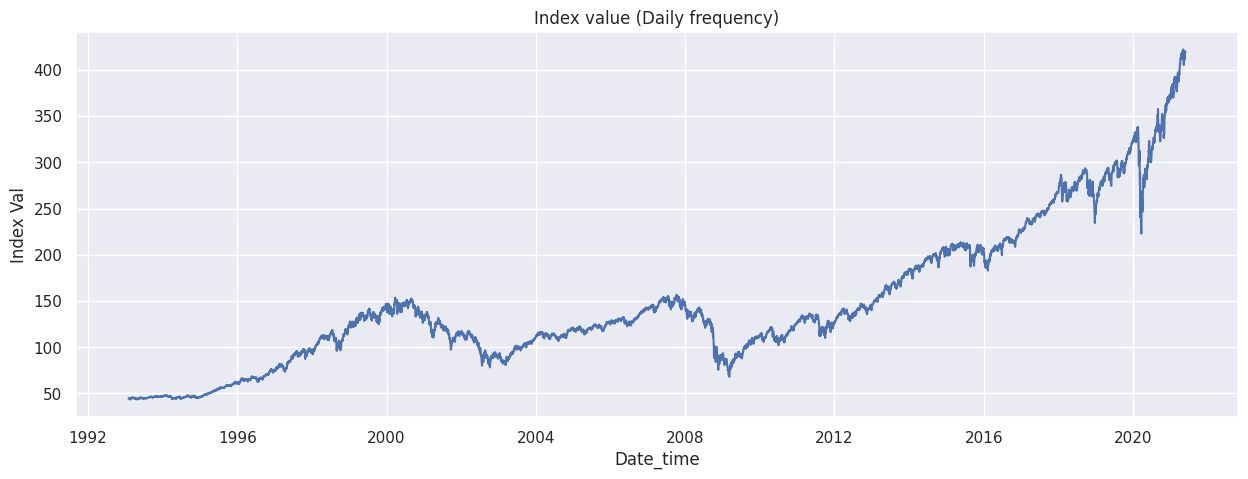

In [ ]:
print('Historical Index value visualization:')
plt.figure(figsize = (15,5))
plt.plot(df_spy_to_plot)
plt.title('Index value (Daily frequency)')
plt.xlabel ('Date_time')
plt.ylabel ('Index Val')
plt.show()

Box plot visualization:


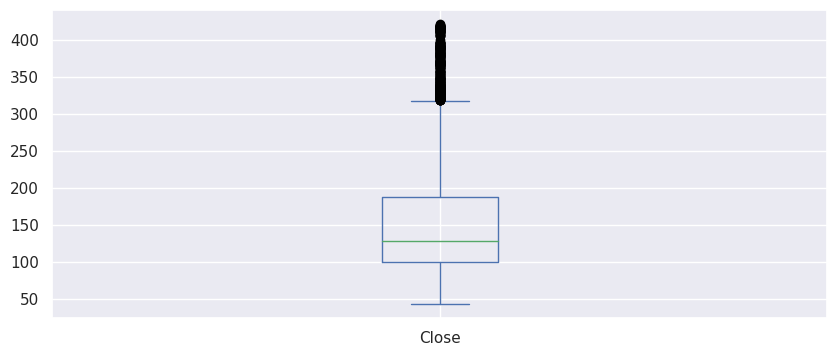

In [ ]:
# Generate Boxplot
print('Box plot visualization:')
df_spy_to_plot.plot(kind='box', figsize = (10,4))
plt.show()

Minimum Close    43.40625
dtype: float64
Maximum Close    422.119995
dtype: float64


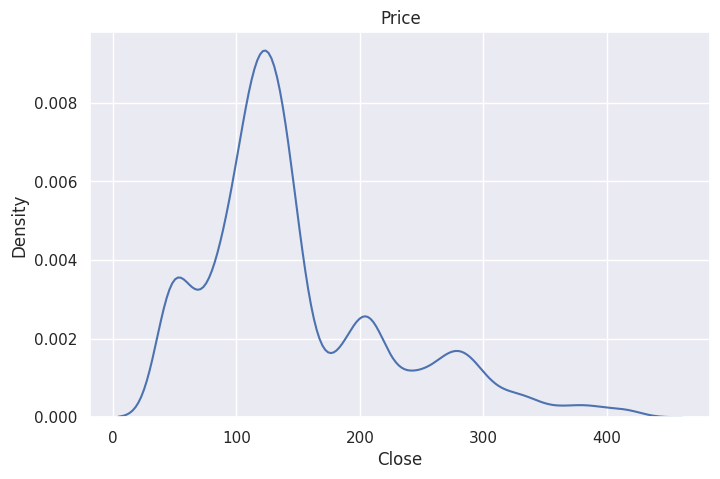

In [ ]:
# Minimum and maximum prices
print('Minimum ' + str(df_spy_to_plot.min()))
print('Maximum ' + str(df_spy_to_plot.max()))

fig, ax1 = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('Price')
sns.kdeplot(df_spy_to_plot['Close'], ax=ax1)
plt.show()

In [ ]:
# seggregating data in train test - 95% train and 5% test
train_size = int(len(df_spy_to_plot) * 0.95)
test_size = len(df_spy_to_plot) - train_size
train, test = df_spy_to_plot.iloc[0:train_size], df_spy_to_plot.iloc[train_size:len(df_spy_to_plot)]
print('Train shape:',train.shape)
print('Test shape:', test.shape)

Train shape: (6777, 1)
Test shape: (357, 1)


In [ ]:
# Scaling the dataset to standard using RobustScaler class which is less sensitive to outliers
from sklearn.preprocessing import RobustScaler

robust = RobustScaler(quantile_range=(25, 75)).fit(train[['Close']])

train['Close'] = robust.transform(train[['Close']])
test['Close'] = robust.transform(test[['Close']])


<ipython-input-31-22ce3a8aa7ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = robust.transform(train[['Close']])
<ipython-input-31-22ce3a8aa7ef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = robust.transform(test[['Close']])


### Create time series data

Select the variable (column) from the data and create the series of data with a window size.

Refer [LSTM Autoencoder](https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713)

In [ ]:
# Split the data into sequences - this is interesting, we get sequences and targets

def create_dataset(X, y, time_steps=1):
  a, b = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    a.append(v)
    b.append(y.iloc[i + time_steps])
  return np.array(a), np.array(b)

# Create sequences with 30 days worth of historical data

n_steps = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['Close']], train['Close'], n_steps)
X_test, y_test = create_dataset(test[['Close']], test['Close'], n_steps)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (6747, 30, 1)
y_train shape: (6747,)
X_test shape: (327, 30, 1)
y_test shape: (327,)


### Build an LSTM Autoencoder

Autoencoder should take a sequence as input and outputs a sequence of the same shape.

Hint: [LSTM Autoencoder](https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713)

In [ ]:
# The model architecture - encoder that accepts
units = 64
dropout = 0.20
optimizer = 'adam'
loss = 'mae'
epochs = 20

model = keras.Sequential()
model.add(keras.layers.LSTM(units=units, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.RepeatVector(n=X_train.shape[1])) # RepeatVector layer simply repeats the input n times.
model.add(keras.layers.LSTM(units=units, return_sequences=True)) # Adding return_sequences=True in LSTM layer makes it return the sequence.
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
# TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer.
model.compile(loss= loss, optimizer=optimizer)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 64)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             65        
 ributed)                                               

### Train the Autoencoder

* Compile and fit the model with required parameters

In [ ]:
history = model.fit(X_train, X_train, epochs=epochs, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/20
190/190 [==============================] - 5s 11ms/step - loss: 0.1610 - val_loss: 0.3370
Epoch 2/20
190/190 [==============================] - 1s 7ms/step - loss: 0.1012 - val_loss: 0.1367
Epoch 3/20
190/190 [==============================] - 1s 7ms/step - loss: 0.1044 - val_loss: 0.2264
Epoch 4/20
190/190 [==============================] - 1s 7ms/step - loss: 0.0950 - val_loss: 0.2936
Epoch 5/20
190/190 [==============================] - 2s 9ms/step - loss: 0.0915 - val_loss: 0.3243
Epoch 6/20
190/190 [==============================] - 2s 10ms/step - loss: 0.0859 - val_loss: 0.2194
Epoch 7/20
190/190 [==============================] - 1s 7ms/step - loss: 0.0884 - val_loss: 0.2173
Epoch 8/20
190/190 [==============================] - 1s 7ms/step - loss: 0.0881 - val_loss: 0.2213
Epoch 9/20
190/190 [==============================] - 1s 7ms/step - loss: 0.0917 - val_loss: 0.3824
Epoch 10/20
190/190 [==============================] - 1s 7ms/step - loss: 0.0945 - val_loss: 0.41

#### Plot metrics and evaluate the model

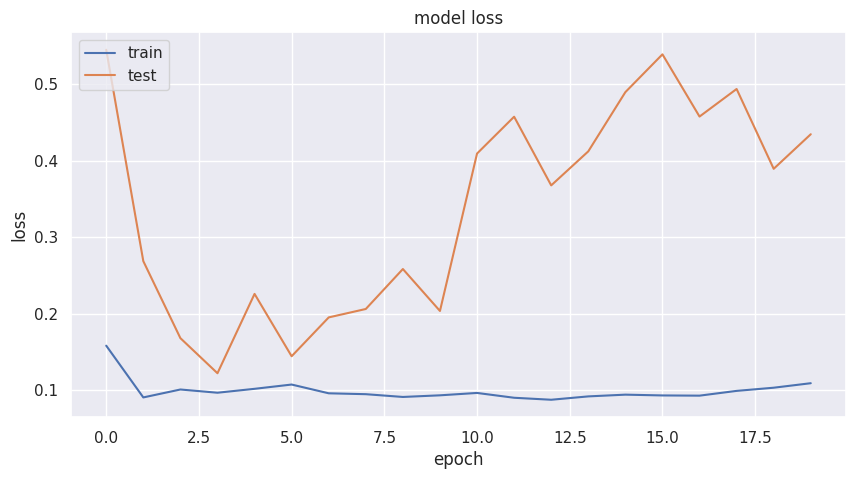

In [ ]:
# history for loss
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_pred = model.predict(X_train)
train_pred.shape

211/211 [==============================] - 1s 3ms/step


(6747, 30, 1)

In [ ]:
train_loss = (np.mean(np.abs(train_pred - X_train), axis=1))
train_pred.shape, train_loss.shape

((6747, 30, 1), (6747, 1))

211/211 [==============================] - 1s 3ms/step


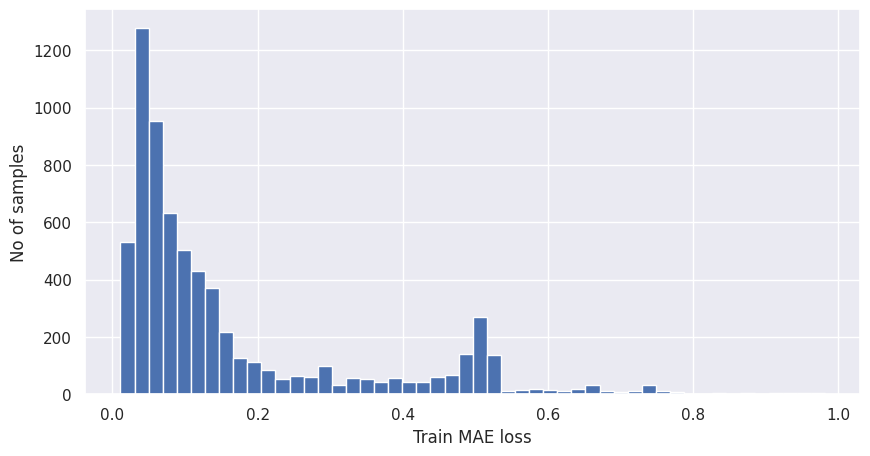

In [ ]:
# Get train MAE loss.
train_pred = model.predict(X_train)
train_loss = np.mean(np.abs(train_pred - X_train), axis=1)

plt.figure(figsize = (10,5))
plt.hist(train_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
# max loss in training data is our threshold - any sample that reports loss more than this will be an anomaly
threshold = np.max(train_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.9817225260415767


In [ ]:
X_train[0].shape, train_pred[0].shape

((30, 1), (30, 1))

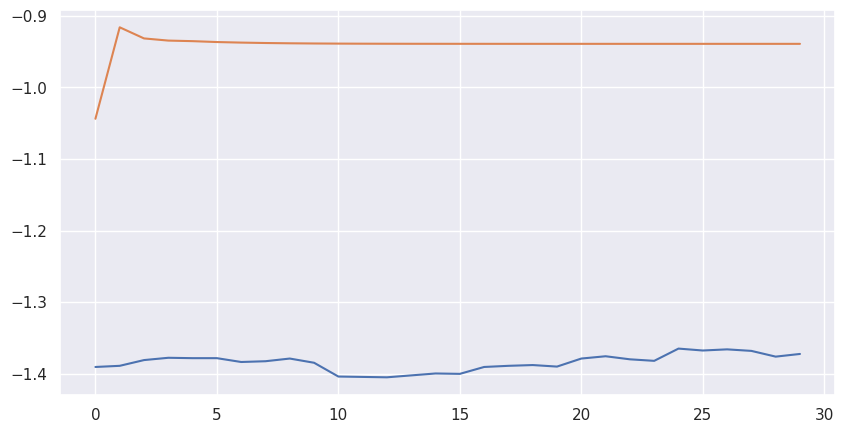

In [ ]:
# reconstructing actual and predicted sequence
plt.figure(figsize = (10,5))
# plt.plot(X_train[0])
plt.plot(train_pred[0])
plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
test_mae_loss = np.mean(np.abs(y_pred - X_test), axis=1)
print("MAE loss shape",test_mae_loss.shape);print();

# reshaping prediction
pred_reshaped = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred_reshaped.shape); print();

print('Test data shape:', X_test.shape); print();

# reshaping test data
X_test_reshaped = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test_reshaped.shape); print();

# error computation
errors = X_test_reshaped - pred_reshaped
print('Errors:', errors.shape); print();

# rmse on test data
RMSE = math.sqrt(mean_squared_error(X_test_reshaped, pred_reshaped))
print('Test RMSE: %.3f' % RMSE)

11/11 [==============================] - 0s 3ms/step
Predict shape: (327, 30, 1)

MAE loss shape (327, 1)

Prediction: (9810, 1)

Test data shape: (327, 30, 1)

Test data: (9810, 1)

Errors: (9810, 1)

Test RMSE: 0.034


In [ ]:
# Detect all the samples which are anomalies. This means whereever the reconstruction error is > threshold
anomalies = test_mae_loss > threshold
print(anomalies.shape)
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

(327, 1)
Number of anomaly samples:  18
Indices of anomaly samples:  (array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [ ]:
dist = np.linalg.norm(X_test - y_pred, axis=1)
#Sorting the scores/diffs and using a 0.80 as cutoff value to pick the threshold

# dist[:10], test_mae_loss[:10]
scores = dist.copy()
print('Score:', scores.shape)

scores.sort()
cut_off = int(0.80 * len(scores))
print('Cutoff value:', cut_off)

threshold = scores[cut_off]
print('Threshold value:', threshold)

Score: (327, 1)
Cutoff value: 261
Threshold value: [0.06199426]


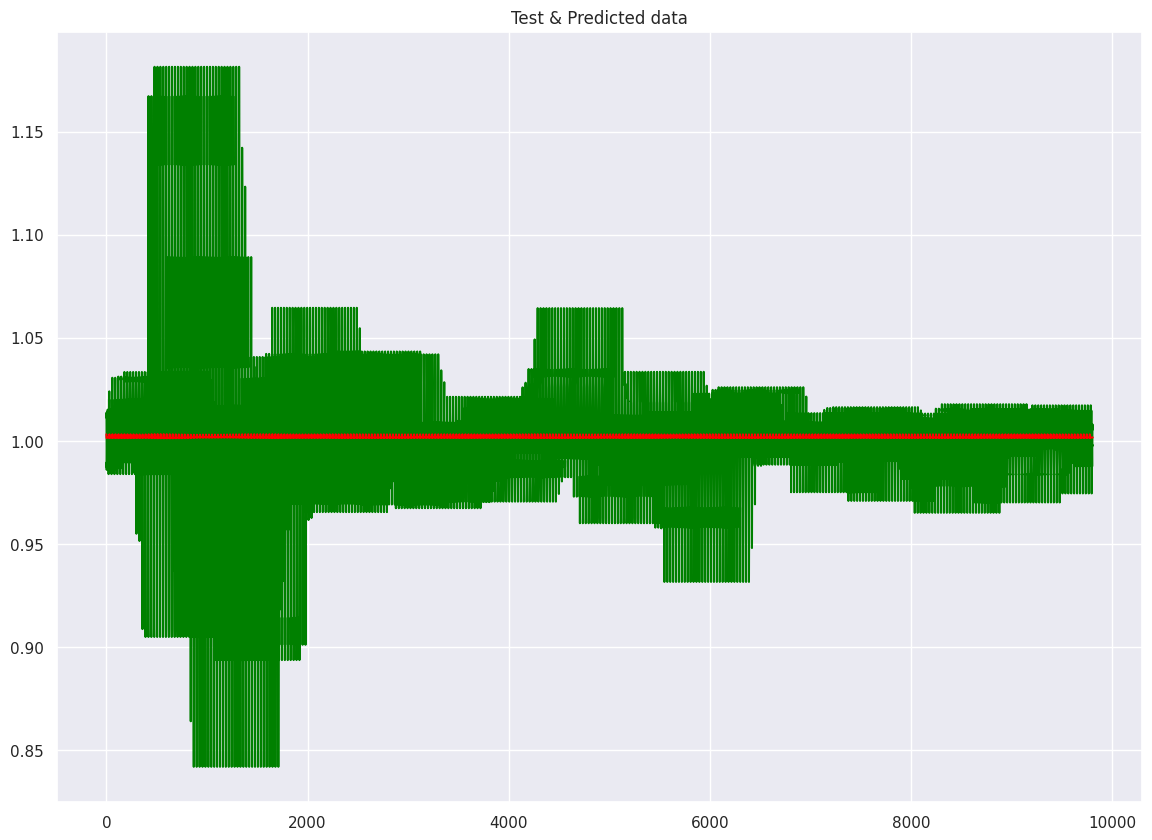

In [ ]:
plt.figure(figsize= (14,10))
plt.plot(X_test_reshaped, color = 'green')
plt.plot(pred_reshaped, color = 'red')
plt.title("Test & Predicted data")
plt.show()

Threshold [0.06199426]


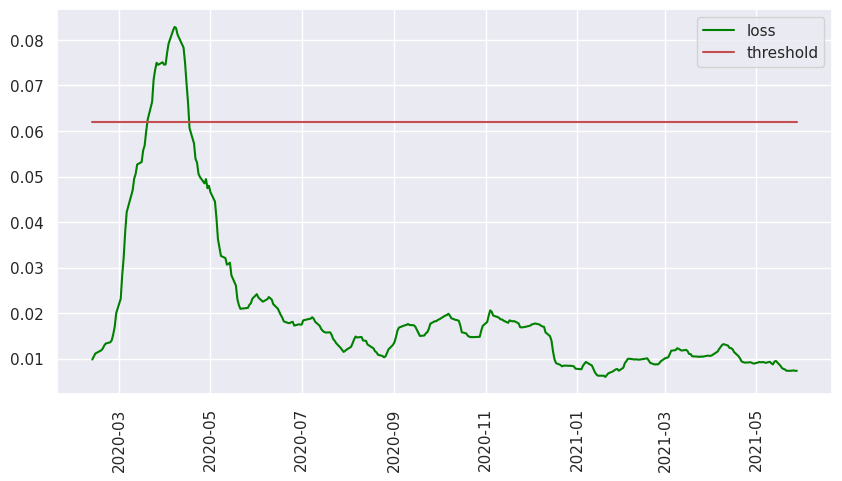

In [ ]:
print("Threshold",threshold)
score = DataFrame(index=test[n_steps:].index)
score['loss'] = test_mae_loss
score['threshold'] = float(threshold)
score['anomaly'] = score['loss'] > score['threshold']
score['Close'] = test[n_steps:].Close

plt.figure(figsize = (10,5))
plt.plot(score.index, score['loss'], color = 'green', label='loss')
plt.plot(score.index, score['threshold'], color = 'r', label='threshold')
plt.xticks(rotation=90)
plt.legend();

### Detect Anomalies in the S&P 500 Index Data

* Predict the data and calculate the loss
* Define threshold and detect the anomalies

Discuss the Impact of COVID19 pandemic on stock prices in terms of anomalies detected during the pandemic period in stock prices

In [ ]:
anomalies = score[score['anomaly'] == True]
x = DataFrame(anomalies.Close)
# x = DataFrame(robust.inverse_transform(x))
x.index = anomalies.index
x.rename(columns = {0: 'inverse_close'}, inplace = True)
# anomalies = anomalies.join(x, how = 'left')
# anomalies = anomalies.drop(columns=['Close'], axis=1)
anomalies

,loss,threshold,anomaly,Close
Date,,,,
2020-03-20,0.062455,0.061994,True,0.864075
2020-03-23,0.066419,0.061994,True,0.841982
2020-03-24,0.071307,0.061994,True,0.918269
2020-03-25,0.073405,0.061994,True,0.932015
2020-03-26,0.074988,0.061994,True,0.986435
2020-03-27,0.074538,0.061994,True,0.957054
2020-03-30,0.075104,0.061994,True,0.988135
2020-03-31,0.074575,0.061994,True,0.973406
2020-04-01,0.074620,0.061994,True,0.893761


In [ ]:
# x = DataFrame(anomalies.inverse_close)
# # x = DataFrame(robust.inverse_transform(x))
# x.index = anomalies.index
# x.rename(columns = {0: 'close'}, inplace = True)
# anomalies = anomalies.join(x, how = 'left')
# anomalies = anomalies.drop(columns=['inverse_close'], axis=1)
# anomalies

In [ ]:
# Recreate
temp = test[n_steps:]
temp

,Close
Date,
2020-02-12,1.030691
2020-02-13,1.029591
2020-02-14,1.031241
2020-02-18,1.028583
2020-02-19,1.033501
...,...
2021-05-24,1.007677
2021-05-25,1.005441
2021-05-26,1.007437


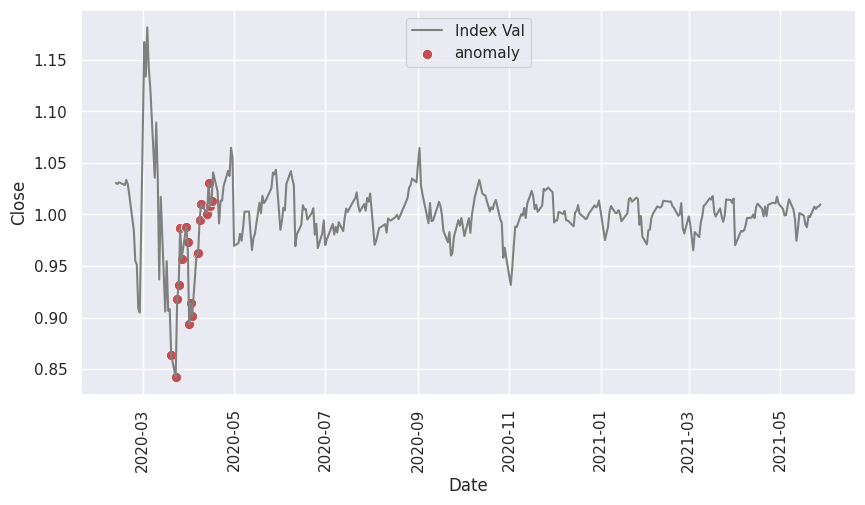

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(temp.index, temp.Close, color = 'gray', label='Index Val');
sns.scatterplot(anomalies['Close'], color=sns.color_palette()[3], s=55, label='anomaly')
plt.xticks(rotation=90)
plt.legend(loc='upper center');

### Report Analysis

* Discuss on the results of T-SNE and PCA
* Dicuss about the results of LSTM autoencoder